In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

In [2]:
from triage.component.catwalk.storage import ProjectStorage
from triage.component.postmodeling.contrast.model_evaluator import ModelEvaluator

In [5]:
from src.utils.general import get_db_conn
from src.utils import project_constants as constants
from src.bill_passage.postmodeling.model_evaluator import ModelEvaluatorACLU

#### Connections

In [6]:
cred_file = '../conf/local/credentials.yaml'
db_conn=get_db_conn(cred_file, conn_type='sqlalchemy')

project_path = 's3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_lt'

#### Model info

In [7]:
model_group_id = 654
model_id = 16402

q = """
    select 
        model_id,
        model_group_id,
        train_end_time,
        train_matrix_uuid,
        matrix_uuid as test_matrix_uuid
    from triage_metadata.models join test_results.prediction_metadata using(model_id) 
    where model_id = {}
""".format(model_id)

model_info = pd.read_sql(q, db_conn).to_dict('records')[0]
model_info

{'model_id': 16402,
 'model_group_id': 654,
 'train_end_time': Timestamp('2018-03-01 00:00:00'),
 'train_matrix_uuid': '605fbb27143a1c95cd05ee3b7b692e8c',
 'test_matrix_uuid': '4ae7556b60a8af3827baf2d94a61320a'}

In [8]:
model_eval = ModelEvaluatorACLU(engine=db_conn, model_group_id=model_group_id, model_id=model_id)

#### Score distributions

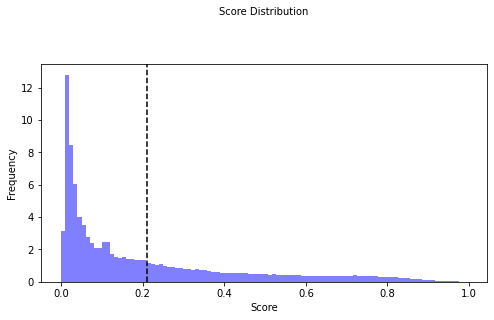

In [9]:
model_eval.plot_score_distribution(
    nbins=100,
    figsize=(8, 4),
    fontsize=10
)

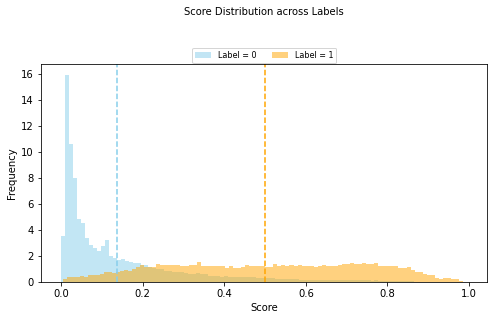

In [10]:
model_eval.plot_score_label_distributions(
    nbins=100,
   label_names = ('Label = 0', 'Label = 1'),
   figsize=(8, 4),
   fontsize=10
)

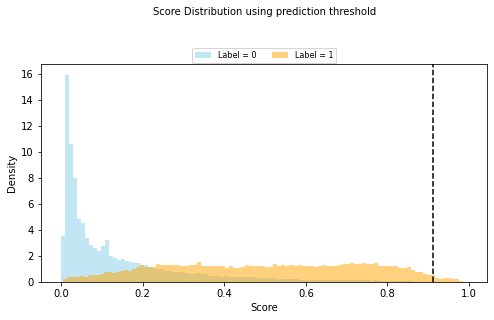

In [11]:
model_eval.plot_score_distribution_thresh(
    param_type='rank_pct',
    param=40,
    nbins=100,
    label_names = ('Label = 0', 'Label = 1'),
    figsize=(8, 4),
    fontsize=10
)

In [12]:
dir(model_eval)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_error_labeler',
 '_error_modeler',
 '_feature_importance_slr',
 'as_of_date',
 'cluster_correlation_features',
 'cluster_correlation_sparsity',
 'compute_AUC',
 'crosstabs',
 'crosstabs_ratio_plot',
 'engine',
 'error_analysis',
 'feature_group_importances',
 'feature_importances',
 'hyperparameters',
 'metadata',
 'model_group_id',
 'model_hash',
 'model_id',
 'model_type',
 'plot_ROC',
 'plot_feature_distribution',
 'plot_feature_distribution_with_score_bands',
 'plot_feature_group_aggregate_importances',
 'plot_feature_importances',
 'plot_feature_importances_std_err',
 'plot_precision_recall_n',
 'plot_recall_fpr_n'

#### Evaluation Curves

<Figure size 432x288 with 0 Axes>

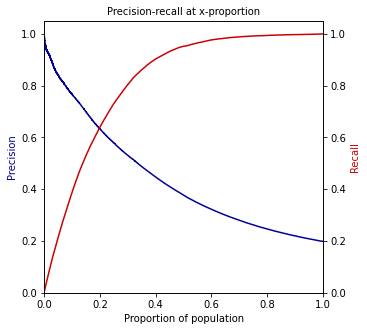

In [13]:
model_eval.plot_precision_recall_n(
    figsize=(5, 5),
    fontsize=10
)

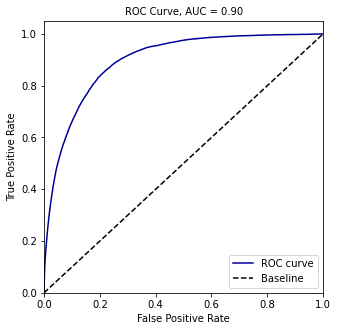

In [39]:
model_eval.plot_ROC(
    figsize=(5, 5),
    fontsize=10
)

In [43]:
# model_eval.plot_recall_fpr_n(
#     figsize=(5, 5),
#     fontsize=10
# )

#### Feature importance

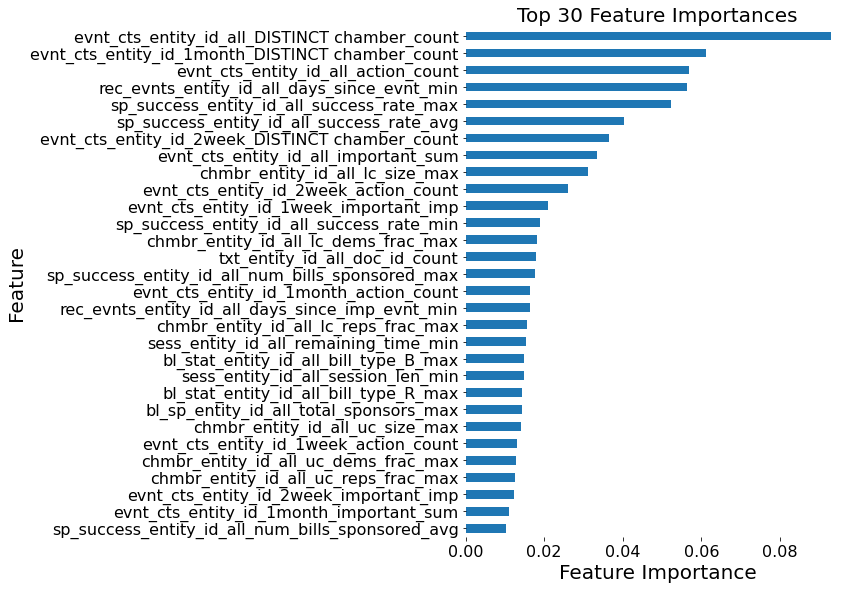

In [14]:
model_eval.plot_feature_importances(
    path=project_path,
    n_features_plots=30,
    figsize=(12, 8),
    fontsize=20
)

2021-06-26 02:55:17 -    INFO Found credentials in shared credentials file: ~/.aws/credentials


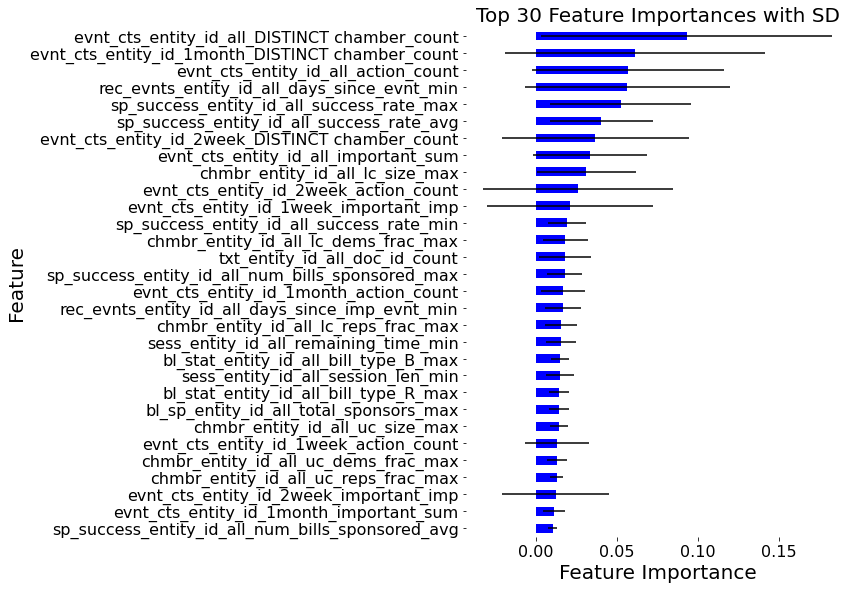

In [15]:
model_eval.plot_feature_importances_std_err(
    path=project_path,
    bar=True,
    n_features_plots=30,
    figsize=(12, 8),
    fontsize=20
)

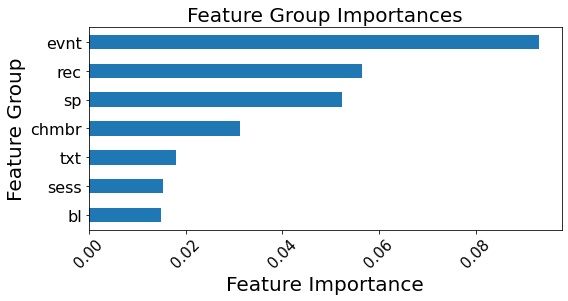

In [71]:
model_eval.plot_feature_group_aggregate_importances(
   n_features_plots=30,
   figsize=(8, 4),
   fontsize=20
)

**Note** -- ModelEvaluator seems to extract the feature group name by splitting on underscores. I have feature group names with underscores. So, some feature groups are grouped together -- (bl_stat, bill_sp) and (rec_evnts, rec_txt)

#### Feature Correlations

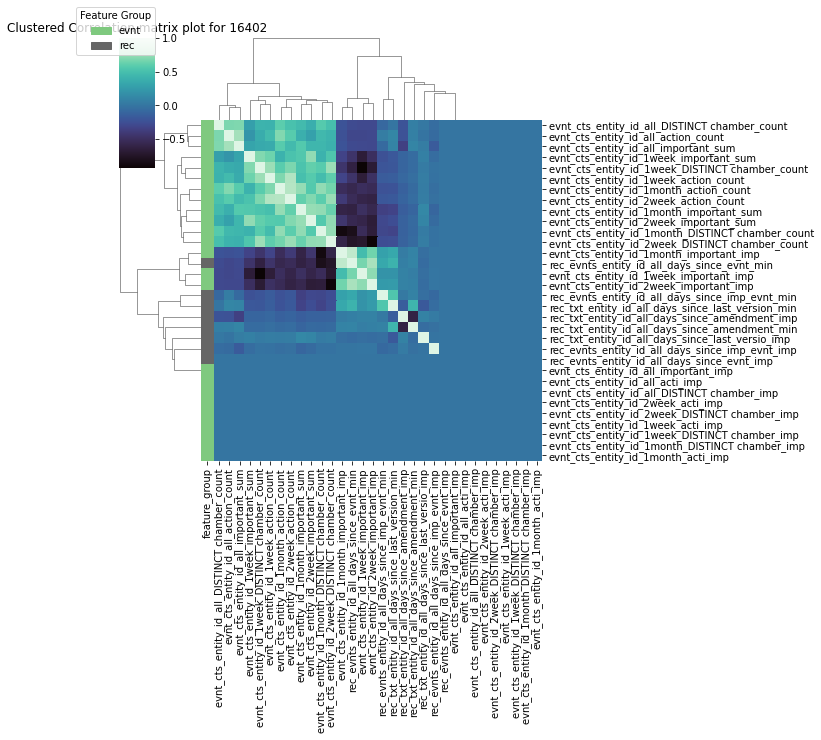

In [65]:
model_eval.cluster_correlation_features(
    path=project_path,
    feature_group_subset_list=['evnt', 'rec'],
    cmap_color_fgroups='Accent',
    cmap_heatmap='mako',
    figsize=(16,16),
    fontsize=12
)

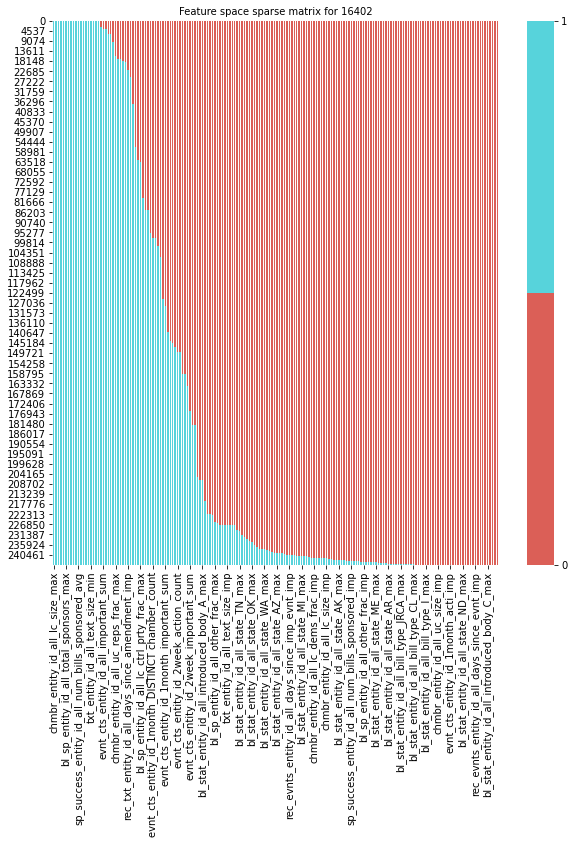

In [66]:
model_eval.cluster_correlation_sparsity(
    path=project_path,
    figsize=(10,10),
    fontsize=10
)

#### Feature Distributions

In [77]:
feature_importances = model_eval.feature_importances(project_path).sort_values('feature_importance', ascending=False)
feature_importances.head()

,model_id,feature,feature_importance,feature_group,rank_abs
130,16402,evnt_cts_entity_id_all_DISTINCT chamber_count,0.093089,evnt,1
112,16402,evnt_cts_entity_id_1month_DISTINCT chamber_count,0.061317,evnt,2
133,16402,evnt_cts_entity_id_all_action_count,0.056821,evnt,3
137,16402,rec_evnts_entity_id_all_days_since_evnt_min,0.056462,rec,4
154,16402,sp_success_entity_id_all_success_rate_max,0.052402,sp,5


2021-06-25 20:31:10 - WARNING No handles with labels found to put in legend.
2021-06-25 20:31:10 - WARNING No handles with labels found to put in legend.
2021-06-25 20:31:10 - WARNING No handles with labels found to put in legend.
2021-06-25 20:31:12 - WARNING No handles with labels found to put in legend.
2021-06-25 20:31:12 - WARNING No handles with labels found to put in legend.
2021-06-25 20:31:12 - WARNING No handles with labels found to put in legend.


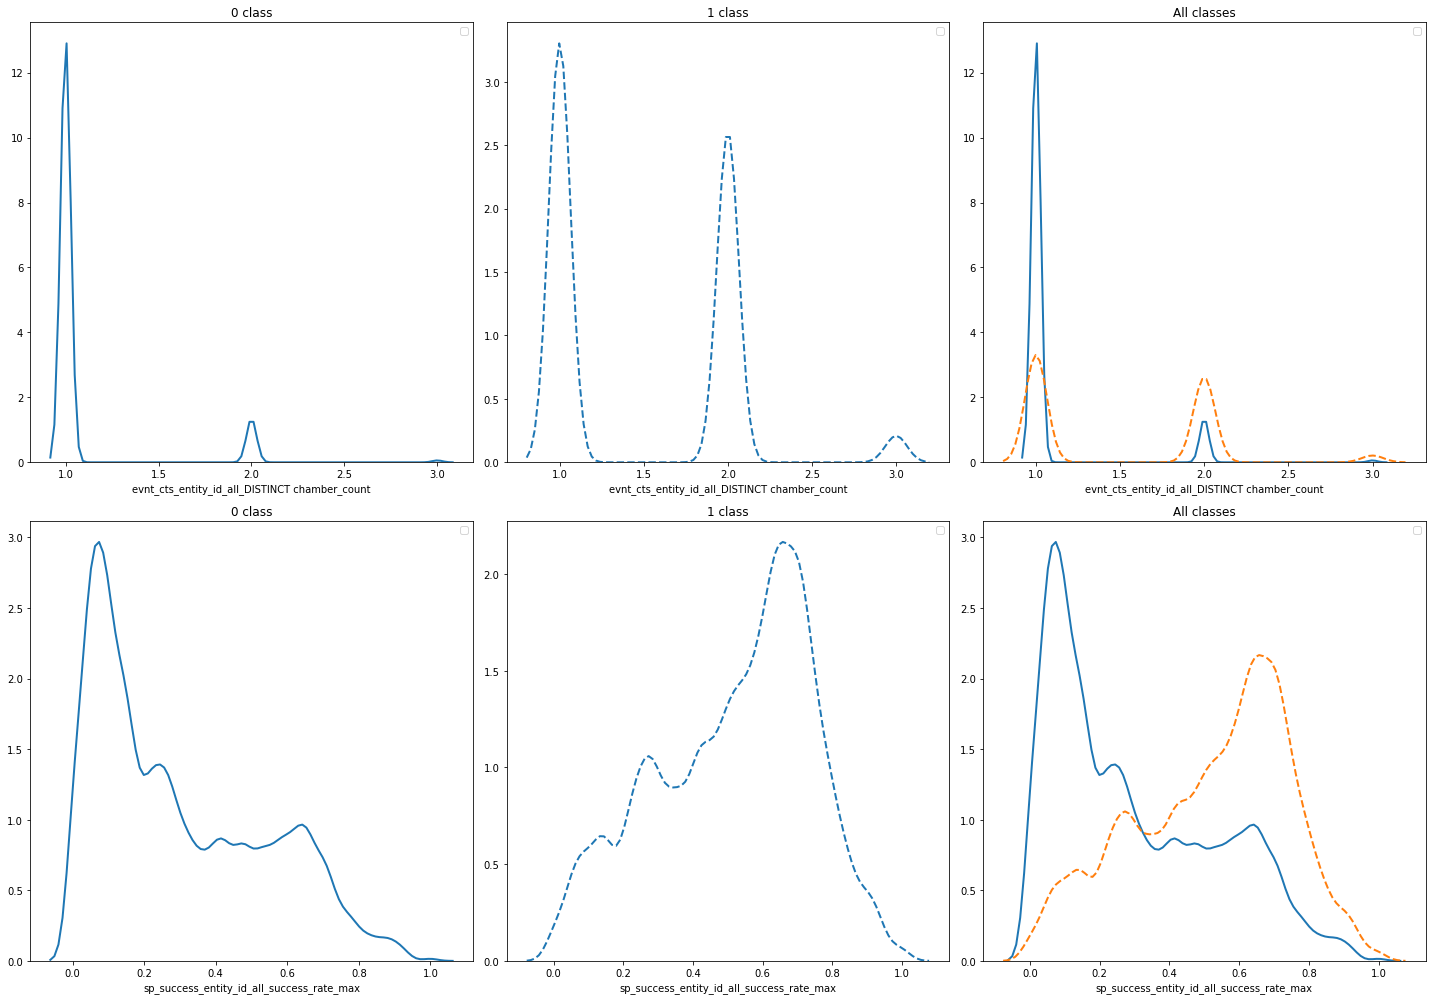

In [81]:
model_eval.plot_feature_distribution(
    path=project_path,
    feature_list=['evnt_cts_entity_id_all_DISTINCT chamber_count', 'sp_success_entity_id_all_success_rate_max']
)

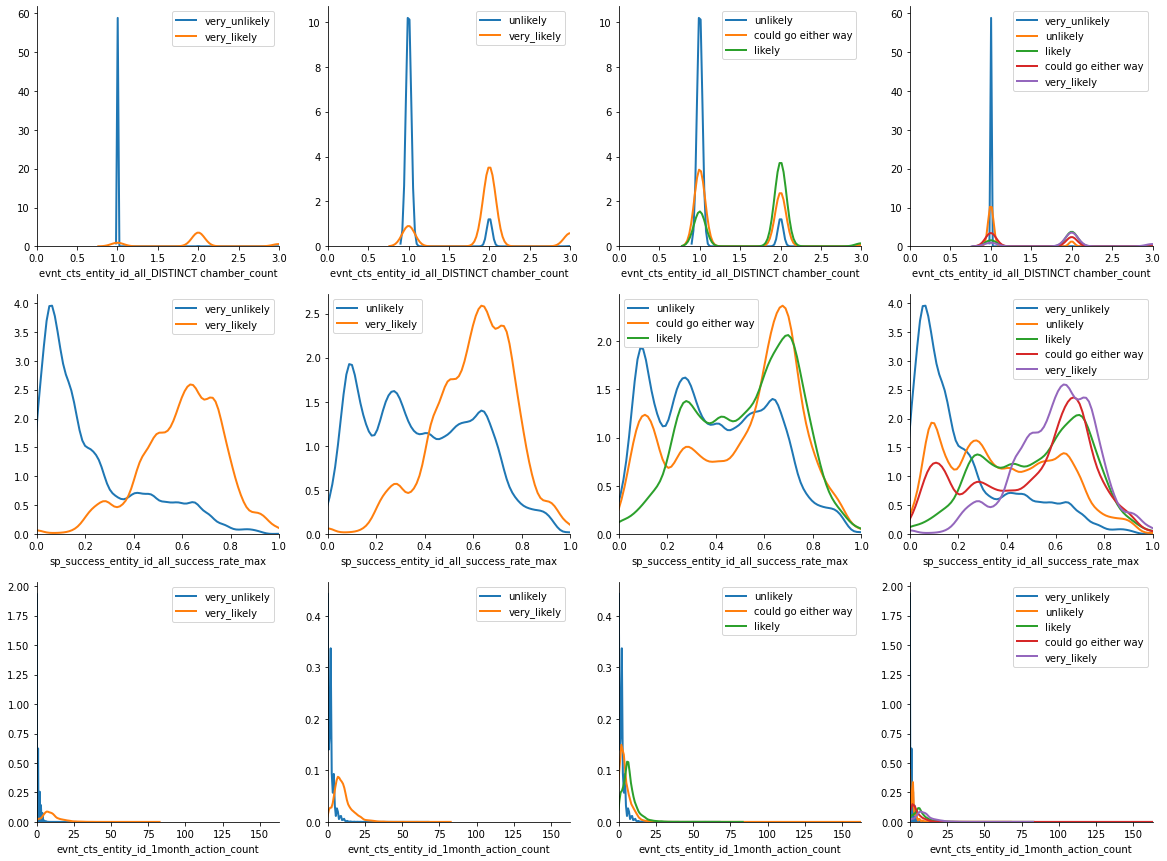

In [8]:
# score_bands = {
#     'will_not_pass': [0, 0.10],
#     'unlikely': [0.10, 0.35],
#     'could go either way': [0.35, 0.55],
#     'likely': [0.55, 0.70],
#     'very_likely': [0.70, 0.90],
#     'will_pass': [0.90, 1.1]
# }

# bin_subsets = {
#     'extremes': ['will_not_pass', 'will_pass'],
#     'second_level': ['unlikely', 'very_likely'],
#     'mid': ['unlikely', 'could go either way', 'likely'],
#     'all': ['unlikely', 'likely' , 'could go either way', 'very_likely', 'will_pass']
# }

score_bands = {
    'very_unlikely': [0, 0.10],
    'unlikely': [0.10, 0.35],
    'could go either way': [0.35, 0.55],
    'likely': [0.55, 0.70],
    'very_likely': [0.70, 1.1],
}

bin_subsets = {
    'extremes': ['very_unlikely', 'very_likely'],
    'second_level': ['unlikely', 'very_likely'],
    'mid': ['unlikely', 'could go either way', 'likely'],
    'all': ['very_unlikely', 'unlikely', 'likely' , 'could go either way', 'very_likely']
}


model_eval.plot_feature_distribution_with_score_bands(
    path=project_path,
    score_bands=score_bands,
    feature_list=[
        'evnt_cts_entity_id_all_DISTINCT chamber_count', 
        'sp_success_entity_id_all_success_rate_max', 
        'evnt_cts_entity_id_1month_action_count',
        ''
    ],
    score_band_subsets=bin_subsets
)